<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/08_pytorch_paper_replicating_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercises

> **Note:** These exercises expect the use of `torchvision` v0.13+ (released July 2022), previous versions may work but will likely have errors.

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**

* [Exercise template notebook for 08](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb).
* [Example solutions notebook for 08](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/08_pytorch_paper_replicating_exercise_solutions.ipynb) (try the exercises *before* looking at this).
    * See a live [video walkthrough of the solutions on YouTube](https://youtu.be/tjpW_BY8y3g) (errors and all).

# import/dataloaders

In [47]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [49]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [50]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [51]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [52]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79a4d846fa90>,
 ['pizza', 'steak', 'sushi'])

In [53]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

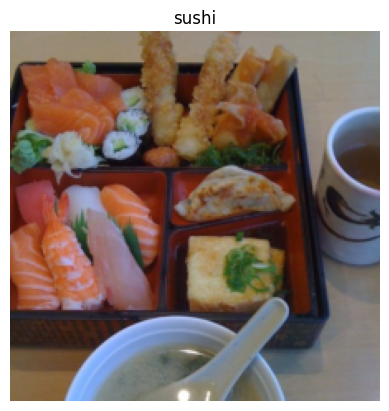

In [54]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).


* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).


## from equation to code

### Patchifier

In [55]:
# patchify images using conv2d
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

image_convd = conv2d(image.unsqueeze(0))
image_convd.shape

torch.Size([1, 768, 14, 14])

showing the conv feature maps from indexes: range(0, 14)


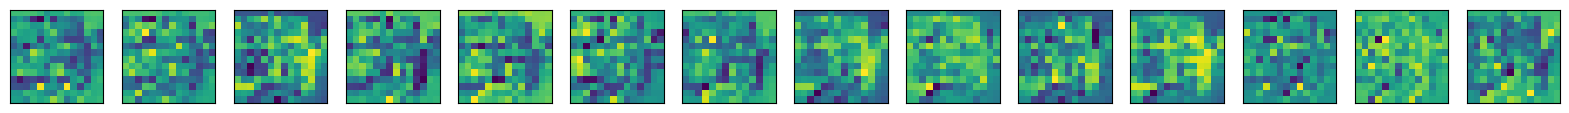

In [56]:
# view image_convd. well atleast the first row
fig, axs = plt.subplots(nrows=1, ncols=14, figsize=(20,20))

print(f"showing the conv feature maps from indexes: {range(0,14)}")
for i, idx in enumerate(range(0,14)):
    image_conv_feature_map = image_convd[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [57]:
# flatten the convd image into 1x1 of [batch, embedding_dims, height, width]
flatten = nn.Flatten(start_dim=2,# flatten height
                     end_dim=3)# flatten width

image_convd_flattened = flatten(image_convd)
image_convd_flattened.shape

torch.Size([1, 768, 196])

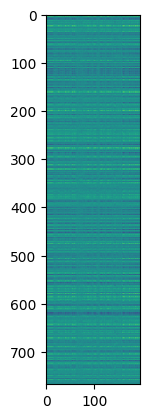

In [58]:
plt.imshow(image_convd_flattened.squeeze().detach().numpy())


torch.Size([1, 196, 768])

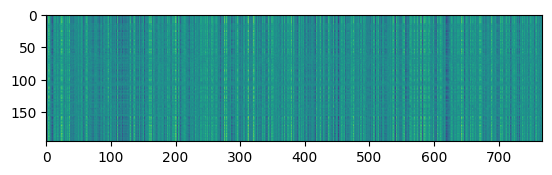

In [59]:
# permutte to change it from [batch, embedded_dim, number_of_patches] to [batch, num_patches, embedded_dim]
image_convd_flattened_reshaped = image_convd_flattened.permute(0, 2, 1)
plt.imshow(image_convd_flattened_reshaped.squeeze().detach().numpy())
image_convd_flattened_reshaped.shape

In [60]:
# add extra learnable class token
# get the batch size and embedding dim
batch_size = image_convd_flattened_reshaped.shape[0]
embedding_dim = image_convd_flattened_reshaped.shape[-1]

# create class token embedding as a learnable parameter
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim),
                           requires_grad=True)

print(f"Patched image shape before adding class token: {image_convd_flattened_reshaped.shape}")
print(f"Class token shape: {class_token.shape}")

# prepend class token
patched_image_with_class_embedding = torch.cat((class_token, image_convd_flattened_reshaped),
                                               dim=1)

print(f"Patched image shape after adding class token: {patched_image_with_class_embedding.shape}")

Patched image shape before adding class token: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patched image shape after adding class token: torch.Size([1, 197, 768])


In [61]:
height, width = image.shape[-2], image.shape[-1]
(height*width) / patch_size**2

196.0

In [62]:
# adding positional embeddings
batch_size = patched_image_with_class_embedding.shape[0]
embedding_dim = patched_image_with_class_embedding.shape[-1]
height, width = image.shape[-2], image.shape[-1]
num_patches = int((height*width) / patch_size**2)

# create positional embedding as a learnable parameter
position_embeddings = nn.Parameter(torch.randn(batch_size, num_patches+1, embedding_dim),
                           requires_grad=True)

patch_plus_position_embedding = patched_image_with_class_embedding + position_embeddings
patch_plus_position_embedding.shape

torch.Size([1, 197, 768])

In [63]:
# putting it all together
class EquationOne(nn.Module):
    def __init__(self,
                 image_size:int=224,
                 patch_size:int=16,
                 in_channels:int=3,
                 embedding_dim:int=768):
        super().__init__()

        assert image_size % patch_size == 0, f"Error: image_size ({image_size}) is not divisible by patch_size ({patch_size})"

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
        num_patches = int((image_size * image_size) / patch_size**2)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim),
                                            requires_grad=True)

    def forward(self, x):
        x = self.flatten(self.patcher(x))
        x = x.permute(0,2,1)
        x = torch.cat((self.class_token, x), dim=1)
        x = x + self.position_embedding
        return x



In [64]:
x = image.unsqueeze(0)
patchifier = EquationOne()
image_patchified = patchifier(x)
image_patchified.shape

torch.Size([1, 197, 768])

### scaled dot product attention
$$
\mathbf{z}_{\ell}^{\prime} = \operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right) + \mathbf{z}_{\ell-1}, \quad \ell = 1 \dots L
$$



<img src="https://www.researchgate.net/publication/333078019/figure/fig1/AS:758304078839808@1557805189409/left-Scaled-Dot-Product-Attention-right-Multi-Head-Attention.png" width=900/>


#### Pseudocode for Scaled Dot-Product Attention:
1. **Multiply**: Compute the dot product between the query (\(\mathbf{Q}\)) and key (\(\mathbf{K}\)) matrices.
2. **Scale**: Divide the resulting dot product by the square root of the dimension of the key vectors (\(\sqrt{D_k}\)) to obtain the scaled dot-product.
3. **Apply Masking** (if needed): Add a mask to the scaled dot-product to prevent attention to certain positions (e.g., for padding or future tokens in the case of autoregressive models).
4. **Apply Softmax**: Apply the softmax function to the masked and scaled dot-product matrix to obtain attention weights.
5. **Dot Product with \(\mathbf{V}\)**: Multiply the attention weights by the value (\(\mathbf{V}\)) matrix to get the final output.



In [65]:
# initialize patchified image
q = k = v = image_patchified

In [66]:
q.shape, k.shape, k.T.shape

(torch.Size([1, 197, 768]),
 torch.Size([1, 197, 768]),
 torch.Size([768, 197, 1]))

In [67]:


# Initialize patchified image (assuming image_patchified is already defined)
q = k = v = image_patchified  # Shape: [batch_size, num_patches, embedded_dim]

# Step 1: Multiply - Calculate the dot product of the query and key matrices using matmul
qk_matmul = torch.matmul(q, k.transpose(-2, -1))  # Shape: [batch_size, num_patches, num_patches]

# Step 2: Scale - Divide the result by the square root of the key's dimension
embedded_dim = k.shape[-1]
qk_scaled = qk_matmul / torch.sqrt(torch.tensor(embedded_dim, dtype=torch.float32))

# Step 3: (Optional) Mask - Add a mask to ignore certain positions (usually in transformers)

# Step 4: Softmax - Apply the softmax function to turn the scaled dot-product into probabilities
softmax = nn.Softmax(dim=-1)
qk_softmaxed = softmax(qk_scaled)  # Shape: [batch_size, num_patches, num_patches]

# Step 5: Multiply with V - Use these probabilities to weigh the values matrix, giving the final output
attn_qkv = torch.matmul(qk_softmaxed, v)  # Shape: [batch_size, num_patches, embedded_dim]

attn_qkv  # This is the final attention output


tensor([[[-0.7493,  0.4317,  0.4663,  ...,  2.0169,  1.3800, -0.1238],
         [ 0.0892, -2.0419, -0.1937,  ...,  1.7911,  0.8872, -0.6750],
         [-0.6546,  1.9253, -0.5684,  ...,  2.0534,  1.8677, -1.1683],
         ...,
         [-0.4376,  0.4448,  0.4060,  ..., -0.1179,  0.9431, -0.8915],
         [ 1.1386, -1.4450, -2.0325,  ..., -0.3514,  0.5683, -0.9801],
         [-0.7785,  0.5048, -1.5890,  ...,  0.9584, -0.0690, -0.8226]]],
       grad_fn=<UnsafeViewBackward0>)

In [68]:
import torch
import torch.nn as nn

class ScaledDotProductAttn(nn.Module):
    def __init__(self, embedding_dim: int = 768):
        super(ScaledDotProductAttn, self).__init__()
        self.embedding_dim = embedding_dim
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        q=k=v = x
        # Matmul between query and transposed key
        qk_matmul = torch.matmul(q, k.transpose(-2, -1))

        # Scale the dot product by the square root of the embedding dimension
        qk_scaled = qk_matmul / torch.sqrt(torch.tensor(self.embedding_dim, dtype=torch.float32))

        # Apply softmax to get attention weights
        qk_softmaxed = self.softmax(qk_scaled)

        # Matmul with value
        attn_output = torch.matmul(qk_softmaxed, v)

        return attn_output



In [69]:
scaled_dot_product_attn = ScaledDotProductAttn()

### Multihead self attention
$$
MSA(z) = [SA_1(z); SA_2(z); \dots; SA_k(z)] U_{msa}, \quad U_{msa} \in \mathbb{R}^{k \cdot D_h \times D}.
$$

In [70]:
# initiallize num_heads
num_heads = 12
# init storage for tensors
self_attn_tensors = []

for i in range(num_heads):
    attn_qkv = scaled_dot_product_attn(image_patchified)
    self_attn_tensors.append(attn_qkv)

sa_concated = torch.concat(self_attn_tensors, dim=-1)
# sa_concated.shape

u_msa = nn.Linear(in_features=sa_concated.shape[-1],
                    out_features=embedding_dim)

msa = u_msa(sa_concated)
msa.shape

torch.Size([1, 197, 768])

In [71]:
# from code to class

class MSA(nn.Module):
    def __init__(self, embedding_dim:int=768, num_heads:int=12):
        super().__init__()
        self.num_heads = num_heads
        self.scaled_dot_product_attn = ScaledDotProductAttn(embedding_dim=embedding_dim)
        self.u_msa = nn.Linear(in_features=embedding_dim*num_heads, out_features=embedding_dim)

    def forward(self, x):
        x = [self.scaled_dot_product_attn(x) for _ in range(self.num_heads)]
        x = torch.concat(x, dim=-1)
        x = self.u_msa(x)
        return x

## compiling the VIT architecture

In [72]:
# putting it all together
class Patchifier(nn.Module):
    """Converts an image into a sequence of patch embeddings."""

    def __init__(self,
                 image_size:int=224,
                 patch_size:int=16,
                 in_channels:int=3,
                 embedding_dim:int=768):
        """
        Args:
            image_size (int): Size of the square input image.
            patch_size (int): Size of each square patch.
            in_channels (int): Number of input image channels.
            embedding_dim (int): Dimension of patch embeddings.
        """
        super().__init__()

        assert image_size % patch_size == 0, f"Error: image_size ({image_size}) is not divisible by patch_size ({patch_size})"

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
        num_patches = int((image_size * image_size) / patch_size**2)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim),
                                            requires_grad=True)

    def forward(self, x):
        print(f"Input image with batch dimension shape: {x.shape}")
        x = self.patcher(x)
        print(f"Patching embedding shape: {x.shape}")
        x = self.flatten(x)
        print(f"Flattened embedding shape: {x.shape}")
        x = x.permute(0,2,1)
        print(f"Permuted Flattened embedding shape: {x.shape}")
        x = torch.cat((self.class_token, x), dim=1)
        print(f"Patch embedding with class token shape: {x.shape}")
        x = x + self.position_embedding
        print(f"Patch and position embedding shape: {x.shape}")
        print("-"*50)
        return x

# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        print(f"Input shape of MSA block: {x.shape}")
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        print(f"Output shape MSA block: {attn_output.shape}")
        print("-"*50)
        return attn_output

# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        print(f"Input shape of MLP block: {x.shape}")
        x = self.layer_norm(x)
        x = self.mlp(x)
        print(f"Output shape MLP block: {x.shape}")
        return x



In [73]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [74]:
x = image.unsqueeze(0)
patchifier = Patchifier()
patch_and_position_embedding = patchifier(x)

# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 768, 14, 14])
Flattened embedding shape: torch.Size([1, 768, 196])
Permuted Flattened embedding shape: torch.Size([1, 196, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
--------------------------------------------------
Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])
--------------------------------------------------
Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [75]:
class TransformerEncoderBlockWithLayers(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # create transformer encoder layer block
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                        nhead=num_heads,
                                                        dim_feedforward=mlp_size,
                                                        dropout=mlp_dropout,
                                                        activation="gelu")
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # 5. Create a forward() method
    def forward(self, x):

        x = self.encoder_layer(x)
        x = self.layer_norm(x)

        return x

In [76]:
x = image.unsqueeze(0)
patchifier = Patchifier()
patch_and_position_embedding = patchifier(x)

transformer_encoder_block = TransformerEncoderBlockWithLayers()

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = transformer_encoder_block(patch_and_position_embedding)
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 768, 14, 14])
Flattened embedding shape: torch.Size([1, 768, 196])
Permuted Flattened embedding shape: torch.Size([1, 196, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
--------------------------------------------------
Output shape MLP block: torch.Size([1, 197, 768])


In [77]:
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlockWithLayers (TransformerEncoderBlockWithLayers)  [1, 197, 768]        [1, 197, 768]        --                   True
├─TransformerEncoderLayer (encoder_layer)                              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─MultiheadAttention (self_attn)                                  [1, 197, 768]        [1, 197, 768]        2,362,368            True
│    └─Dropout (dropout1)                                              [1, 197, 768]        [1, 197, 768]        --                   --
│    └─LayerNorm (norm1)                                               [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Linear (linear1)                                                [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    └─Dropout (dropout)

In [81]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        """
        Initialize ViT model.

        Args:
            img_size (int): Input image size.
            in_channels (int): Number of input channels.
            patch_size (int): Size of image patches.
            num_transformer_layers (int): Number of transformer layers.
            embedding_dim (int): Dimension of token embeddings.
            mlp_size (int): Dimension of MLP hidden layer.
            num_heads (int): Number of attention heads.
            attn_dropout (float): Dropout rate for attention.
            mlp_dropout (float): Dropout rate for MLP.
            embedding_dropout (float): Dropout rate for embeddings.
            num_classes (int): Number of output classes.
        """
        super().__init__() # don't forget the super().__init__()!

        self.patchifier = Patchifier(image_size=img_size,
                                     patch_size=patch_size,
                                     in_channels=in_channels,
                                     embedding_dim=embedding_dim)
        # Dropout for embeddings
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Create a single TransformerEncoderLayer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                   nhead=num_heads,
                                                   dim_feedforward=mlp_size,
                                                   dropout=mlp_dropout,
                                                   activation='gelu'
                                                   )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layer,
                                                         num_layers=num_transformer_layers,
                                                         norm=nn.LayerNorm(embedding_dim))

        # Create classifier head
        self.classifier = nn.Linear(in_features=embedding_dim,
                                    out_features=num_classes)

    # 11. Create a forward() method
    def forward(self, x):
        """
        Forward pass of ViT.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """

        # Create patch embedding
        x = self.patchifier(x)

        # Apply embedding dropout
        x = self.embedding_dropout(x)

        # Pass through transformer encoder layers
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [79]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 768, 14, 14])
Flattened embedding shape: torch.Size([1, 768, 196])
Permuted Flattened embedding shape: torch.Size([1, 196, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
--------------------------------------------------


tensor([[ 0.3770, -0.5915,  0.2635]], grad_fn=<AddmmBackward0>)

# 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.


* You should be able to import an entire ViT model using something like`from vit import ViT`.


In [86]:

%%writefile vit.py

import torch
from torch import nn

# putting it all together
class Patchifier(nn.Module):
    """Converts an image into a sequence of patch embeddings."""

    def __init__(self,
                 image_size:int=224,
                 patch_size:int=16,
                 in_channels:int=3,
                 embedding_dim:int=768):
        """
        Args:
            image_size (int): Size of the square input image.
            patch_size (int): Size of each square patch.
            in_channels (int): Number of input image channels.
            embedding_dim (int): Dimension of patch embeddings.
        """
        super().__init__()

        assert image_size % patch_size == 0, f"Error: image_size ({image_size}) is not divisible by patch_size ({patch_size})"

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
        num_patches = int((image_size * image_size) / patch_size**2)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim),
                                            requires_grad=True)

    def forward(self, x):
        print(f"Input image with batch dimension shape: {x.shape}")
        x = self.patcher(x)
        print(f"Patching embedding shape: {x.shape}")
        x = self.flatten(x)
        print(f"Flattened embedding shape: {x.shape}")
        x = x.permute(0,2,1)
        print(f"Permuted Flattened embedding shape: {x.shape}")
        x = torch.cat((self.class_token, x), dim=1)
        print(f"Patch embedding with class token shape: {x.shape}")
        x = x + self.position_embedding
        print(f"Patch and position embedding shape: {x.shape}")
        print("-"*50)
        return x

# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        """
        Initialize ViT model.

        Args:
            img_size (int): Input image size.
            in_channels (int): Number of input channels.
            patch_size (int): Size of image patches.
            num_transformer_layers (int): Number of transformer layers.
            embedding_dim (int): Dimension of token embeddings.
            mlp_size (int): Dimension of MLP hidden layer.
            num_heads (int): Number of attention heads.
            attn_dropout (float): Dropout rate for attention.
            mlp_dropout (float): Dropout rate for MLP.
            embedding_dropout (float): Dropout rate for embeddings.
            num_classes (int): Number of output classes.
        """
        super().__init__() # don't forget the super().__init__()!

        self.patchifier = Patchifier(image_size=img_size,
                                     patch_size=patch_size,
                                     in_channels=in_channels,
                                     embedding_dim=embedding_dim)
        # Dropout for embeddings
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Create a single TransformerEncoderLayer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                   nhead=num_heads,
                                                   dim_feedforward=mlp_size,
                                                   dropout=mlp_dropout,
                                                   activation='gelu'
                                                   )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layer,
                                                         num_layers=num_transformer_layers,
                                                         norm=nn.LayerNorm(embedding_dim))

        # Create classifier head
        self.classifier = nn.Linear(in_features=embedding_dim,
                                    out_features=num_classes)

    # 11. Create a forward() method
    def forward(self, x):
        """
        Forward pass of ViT.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """

        # Create patch embedding
        x = self.patchifier(x)

        # Apply embedding dropout
        x = self.embedding_dropout(x)

        # Pass through transformer encoder layers
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

Writing vit.py


In [87]:
!python vit.py


In [88]:

from vit import ViT

x = image.unsqueeze(0)
# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 768, 14, 14])
Flattened embedding shape: torch.Size([1, 768, 196])
Permuted Flattened embedding shape: torch.Size([1, 196, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
--------------------------------------------------


tensor([[ 0.1960, -0.2845, -0.2139]], grad_fn=<AddmmBackward0>)

# 3. Train a pretrained ViT feature extractor model

(like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets).
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).


# 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights

from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* **Note:** ViT pretrained with SWAG weights has a minimum input image size of `(384, 384)` (the pretrained ViT in exercise 3 has a minimum input size of `(224, 224)`), though this is accessible in the weights `.transforms()` method.


# 5. Research some of the following topics from Table 3

 in the ViT paper that we miss and write a sentence about each and how it might help with training:
* ImageNet-21k pretraining (more data).
* Learning rate warmup.
* Learning rate decay.
* Gradient clipping.